In [180]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [181]:
# Configuration
NUM_CLIENTS = 10
MALICIOUS_FRACTION = 0.1
NUM_ROUNDS = 20
POISON_FRACTION = 1.0
ATTACK_TYPE = "random_input"  # Options: "inverted", "targeted", "random_label", "random_input", "none", "backdoor"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


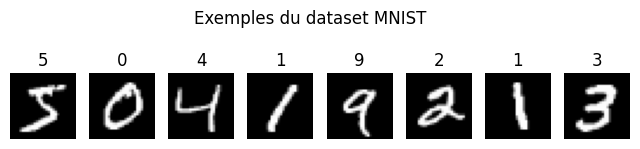

In [182]:
# MNIST loader
mnist_transform = transforms.ToTensor()
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=mnist_transform)

# Affichage
plt.figure(figsize=(8, 2))
for i in range(8):
    image, label = mnist_data[i]
    plt.subplot(1, 8, i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(str(label))
    plt.axis('off')
plt.suptitle("Exemples du dataset MNIST")
plt.show()

In [183]:
# Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)


In [184]:
# Dataset
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


In [185]:
# Partitioning
client_data = [[] for _ in range(NUM_CLIENTS)]
for i, (x, y) in enumerate(trainset):
    client_data[i % NUM_CLIENTS].append((x, y))


In [186]:
# Inverted loss
def inverted_loss(output, target):
    loss = nn.CrossEntropyLoss()(output, target)
    return 1. / (loss + 1e-6)


In [187]:
# Poisoning strategies
def poison_data(data, attack_type, target_class = 0):
    poisoned = []
    for x, y in data:
        if random.random() > POISON_FRACTION or attack_type is None:
            poisoned.append((x, y))
            continue
        if attack_type == "targeted":
            new_y = (y + 1) % 10
        elif attack_type == "random_label":
            new_y = random.randint(0, 9)
        elif attack_type == "random_input":
            x = x + 0.5 * torch.randn_like(x)
            x = torch.clamp(x, 0., 1.)
            new_y = y
        elif attack_type == "inverted":
            new_y = y
        elif attack_type == "backdoor":
            x[:, 25:28, 25:28] = 1.0
            new_y = target_class
        else:
            new_y = y
        poisoned.append((x, new_y))
    return poisoned


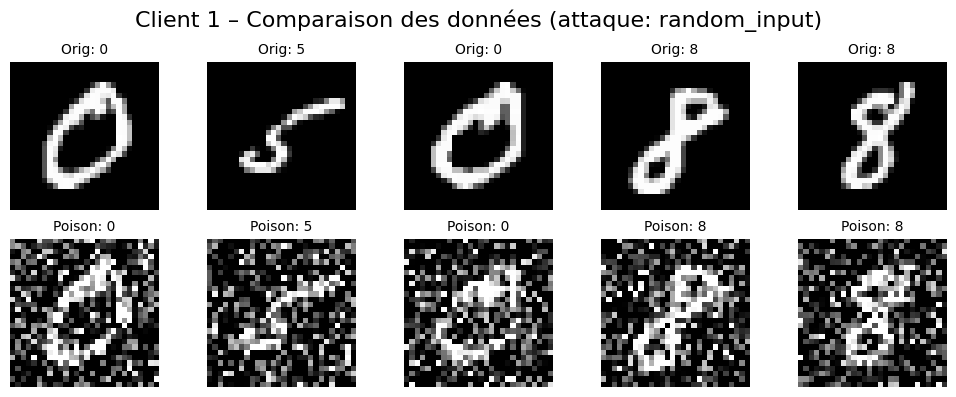

In [188]:
def show_poisoning_comparison(client_id, attack_type="backdoor", num_samples=5, target_class=0):
    original = client_data[client_id][:num_samples]
    poisoned = poison_data(client_data[client_id][:num_samples], attack_type, target_class)

    fig, axes = plt.subplots(2, num_samples, figsize=(2 * num_samples, 4))
    fig.suptitle(f"Client {client_id} – Comparaison des données (attaque: {attack_type})", fontsize=16)

    for i in range(num_samples):
        # Ligne 1 : données originales
        x_orig, y_orig = original[i]
        axes[0, i].imshow(x_orig.squeeze(), cmap="gray")
        axes[0, i].set_title(f"Orig: {y_orig}", fontsize=10)
        axes[0, i].axis("off")

        # Ligne 2 : données modifiées
        x_poison, y_poison = poisoned[i]
        axes[1, i].imshow(x_poison.squeeze(), cmap="gray")
        axes[1, i].set_title(f"Poison: {y_poison}", fontsize=10)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# 🔍 Exemple :
show_poisoning_comparison(client_id=1, attack_type="random_input")


In [189]:
# Local training
def local_train(model, data, use_inverted=False, epochs=1, lr=0.05):
    model = copy.deepcopy(model).to(DEVICE)
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = inverted_loss if use_inverted else nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
    return model.cpu().state_dict()


In [190]:
# Evaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total


In [191]:

def evaluate_with_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Matrice de confusion")
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


In [192]:
# Federated training
global_model = MLP()
acc_list = []


Round 1: Accuracy = 0.7192
Round 2: Accuracy = 0.8169
Round 3: Accuracy = 0.8576
Round 4: Accuracy = 0.8807
Round 5: Accuracy = 0.8919
Round 6: Accuracy = 0.8985
Round 7: Accuracy = 0.9046
Round 8: Accuracy = 0.9102
Round 9: Accuracy = 0.9126
Round 10: Accuracy = 0.9145
Round 11: Accuracy = 0.9191
Round 12: Accuracy = 0.9198
Round 13: Accuracy = 0.9226
Round 14: Accuracy = 0.9265
Round 15: Accuracy = 0.9273
Round 16: Accuracy = 0.9308
Round 17: Accuracy = 0.9322
Round 18: Accuracy = 0.9351
Round 19: Accuracy = 0.9352
Round 20: Accuracy = 0.9378


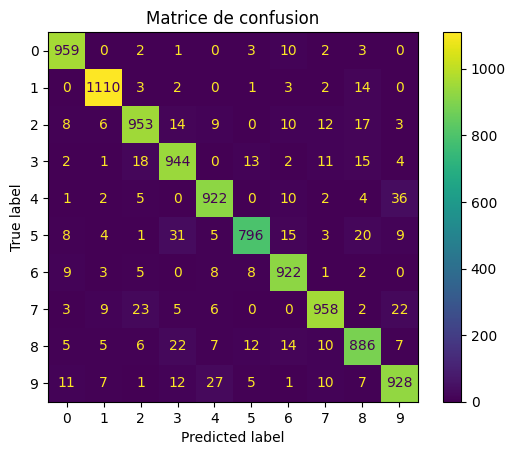

Accuracy: 0.9378


0.9378

In [193]:
for rnd in range(NUM_ROUNDS):
    local_weights = []
    for i in range(NUM_CLIENTS):
        local_model = MLP()
        local_model.load_state_dict(global_model.state_dict())
        is_malicious = (i < int(NUM_CLIENTS * MALICIOUS_FRACTION))
        attack_mode = ATTACK_TYPE if is_malicious else None
        poisoned_dataset = poison_data(client_data[i], attack_mode, target_class=0)
        weights = local_train(local_model, poisoned_dataset, use_inverted=(is_malicious and ATTACK_TYPE == "inverted"))
        local_weights.append(weights)
    # Aggregation
    new_state_dict = copy.deepcopy(local_weights[0])
    for k in new_state_dict.keys():
        for i in range(1, NUM_CLIENTS):
            new_state_dict[k] += local_weights[i][k]
        new_state_dict[k] = torch.div(new_state_dict[k], NUM_CLIENTS)
    global_model.load_state_dict(new_state_dict)
    acc = evaluate(global_model.to(DEVICE), testloader)
    acc_list.append(acc)
    print(f"Round {rnd+1}: Accuracy = {acc:.4f}")

evaluate_with_confusion_matrix(global_model.to(DEVICE), testloader)


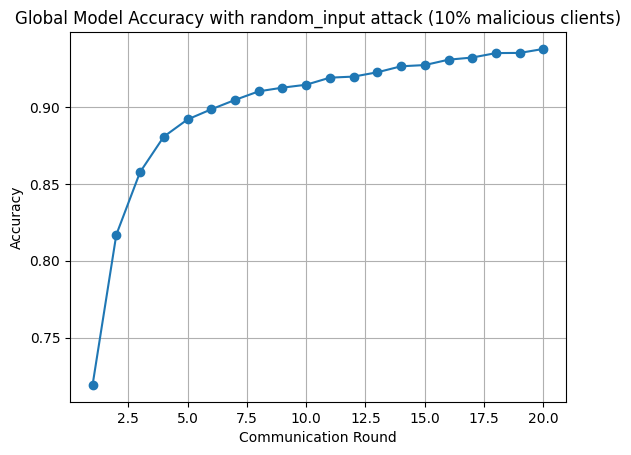

In [194]:
# Plot
plt.plot(range(1, NUM_ROUNDS + 1), acc_list, marker='o')
plt.title(f"Global Model Accuracy with {ATTACK_TYPE} attack ({int(MALICIOUS_FRACTION*100)}% malicious clients)")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
